#  Integrated Decision Gradients (IDG)

**Integrated Decision Gradients (IDG)** is an extension to the traditional **Integrated Gradients (IG)** method.  
Unlike IG, which treats each interpolated step equally, IDG weighs the gradients based on how much the model's prediction (logit) changes between steps.  
This allows IDG to highlight steps that are more critical to the model's decision-making process.

---

##  Mathematical Formulation

$$
IDG_i(x) = (x_i - x_i') \times \int_{\alpha=0}^{1} 
\underbrace{
\frac{\partial F(x_i' + \alpha (x_i - x_i'))}{\partial x_i}
}_{\text{Traditional IG}} 
\times 
\underbrace{
\frac{\partial F(x_i' + \alpha (x_i - x_i'))}{\partial \alpha}
}_{\text{Importance Factor}} d\alpha
$$

---

**Where:**

- $x$: Input  
- $x'$: Baseline (e.g., black image or blurred version)  
- $F$: Model output  
- $\alpha$: Interpolation coefficient between 0 and 1  
- $\frac{\partial F}{\partial x}$: Gradient of model output w.r.t. input  
- $\frac{\partial F}{\partial \alpha}$: Change in model output across interpolation (importance factor)


---

 This formulation emphasizes regions of the input that contribute the most to the change in model decision along the path from baseline to input.


---

##  Workflow

1. **Compute difference** between the input and baseline image.
2. **Generate interpolated images** along the straight-line path between baseline and input.
3. **Pass interpolated images** through the model to obtain class logits.
4. **Calculate slope**, i.e., the change in logits between consecutive interpolation steps.
5. **Allocate more α-steps** to regions with high slope (adaptive sampling).
6. **Recompute interpolated images** using the new adaptive α values.
7. **Compute gradients** at each α-point with respect to the target class.
8. **Weight gradients** using slope values and α-step sizes.
9. **Average weighted gradients** and multiply by input-baseline difference to get the final attribution map.

---



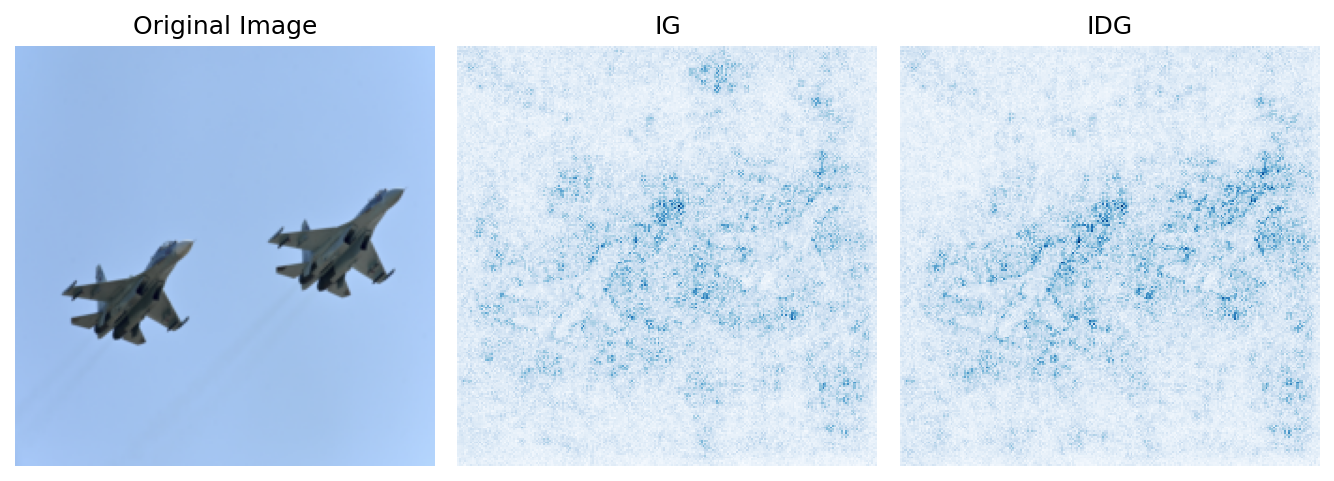

In [18]:
# IG and IDG with Optional Adaptive Sampling + Visualization (Corrected Version)
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
from PIL import Image

def IG(input, model, steps, batch_size, baseline, device, target_class):
    if steps % batch_size != 0:
        print("steps must be evenly divisible by batch size!")
        return 0

    loops = steps // batch_size

    if not torch.is_tensor(baseline):
        baseline = torch.full(input.shape, baseline, dtype=torch.float)

    input = input.to(device)
    baseline = baseline.to(device)
    baseline_diff = input - baseline

    alphas = torch.linspace(0, 1, steps).reshape(steps, 1, 1, 1).to(device)
    gradients = torch.zeros((steps, input.shape[1], input.shape[2], input.shape[3])).to(device)

    for i in range(loops):
        start = i * batch_size
        end = (i + 1) * batch_size
        interp_imgs = baseline + alphas[start:end] * baseline_diff
        gradients[start:end], _ = getGradientsParallel(interp_imgs, model, target_class)

    grads = gradients.mean(dim=0)
    grads *= baseline_diff[0]  # corrected shape match

    return grads.squeeze()

def IDG(input, model, steps, batch_size, baseline, device, target_class, use_adaptive_sampling=True):
    if batch_size == 0 or steps % batch_size != 0:
        print("steps must be evenly divisible by batch size!")
        return 0

    loops = steps // batch_size

    if not torch.is_tensor(baseline):
        baseline = torch.full(input.shape, baseline, dtype=torch.float)

    input = input.to(device)
    baseline = baseline.to(device)
    baseline_diff = input - baseline

    if use_adaptive_sampling:
        slopes, step_size = getSlopes(baseline, baseline_diff, model, steps, batch_size, device, target_class)
        alphas, alpha_substep_size = getAlphaParameters(slopes, steps, step_size)
    else:
        alphas = torch.linspace(0, 1, steps)
        alpha_substep_size = torch.full((steps,), 1.0 / steps)

    alphas = alphas.reshape(steps, 1, 1, 1).to(device)
    alpha_substep_size = alpha_substep_size.reshape(steps, 1, 1, 1).to(device)

    gradients = torch.zeros((steps, input.shape[1], input.shape[2], input.shape[3])).to(device)
    logits = torch.zeros(steps).to(device)

    for i in range(loops):
        start = i * batch_size
        end = (i + 1) * batch_size
        interp_imgs = baseline + alphas[start:end] * baseline_diff
        gradients[start:end], logits[start:end] = getGradientsParallel(interp_imgs, model, target_class)

    if use_adaptive_sampling:
        slopes = torch.zeros(steps).to(device)
        for i in range(steps - 1):
            slopes[i + 1] = (logits[i + 1] - logits[i]) / (alphas[i + 1] - alphas[i])
        slopes[0] = 0
        gradients *= slopes.reshape(steps, 1, 1, 1)
        gradients *= alpha_substep_size

    grads = gradients.mean(dim=0)
    grads *= baseline_diff[0]  # corrected shape match

    return grads.squeeze()

def getGradientsParallel(inputs, model, target_class):
    inputs.requires_grad = True  # ensure grad tracking
    output = model(inputs)
    scores = output[:, target_class]
    gradients = torch.autograd.grad(scores, inputs, grad_outputs=torch.ones_like(scores))[0]
    return gradients.detach().squeeze(), scores.detach().squeeze()

def getPredictionParallel(inputs, model, target_class):
    output = model(inputs)
    scores = output[:, target_class].detach()
    return scores.squeeze()

def getSlopes(baseline, baseline_diff, model, steps, batch_size, device, target_class):
    loops = steps // batch_size
    alphas = torch.linspace(0, 1, steps).reshape(steps, 1, 1, 1).to(device)
    logits = torch.zeros(steps).to(device)
    for i in range(loops):
        start = i * batch_size
        end = (i + 1) * batch_size
        interp_imgs = baseline + alphas[start:end] * baseline_diff
        logits[start:end] = getPredictionParallel(interp_imgs, model, target_class)
    slopes = torch.zeros(steps).to(device)
    x_diff = float(alphas.squeeze()[1] - alphas.squeeze()[0])
    for i in range(steps - 1):
        slopes[i + 1] = (logits[i + 1] - logits[i]) / x_diff
    return slopes, x_diff

def getAlphaParameters(slopes, steps, step_size):
    slopes_0_1_norm = (slopes - torch.min(slopes)) / (torch.max(slopes) - torch.min(slopes))
    slopes_0_1_norm[0] = 0
    slopes_sum_1_norm = slopes_0_1_norm / torch.sum(slopes_0_1_norm)
    sample_placements_float = torch.mul(slopes_sum_1_norm, steps)
    sample_placements_int = sample_placements_float.type(torch.int)
    remaining_to_fill = steps - torch.sum(sample_placements_int)
    non_zeros = torch.where(sample_placements_int != 0)[0]
    sample_placements_float[non_zeros] = -1
    remaining_hi_lo = torch.flip(torch.sort(sample_placements_float)[1], dims=[0])
    sample_placements_int[remaining_hi_lo[0:remaining_to_fill]] = 1
    alphas = torch.zeros(steps)
    alpha_substep_size = torch.zeros(steps)
    alpha_start_index = 0
    alpha_start_value = 0
    for num_samples in sample_placements_int:
        if num_samples == 0:
            continue
        alphas[alpha_start_index: alpha_start_index + num_samples] = torch.linspace(
            alpha_start_value, alpha_start_value + step_size, num_samples + 1)[0:num_samples]
        alpha_substep_size[alpha_start_index: alpha_start_index + num_samples] = step_size / num_samples
        alpha_start_index += num_samples
        alpha_start_value += step_size
    return alphas, alpha_substep_size

def compute_and_visualize_attributions(input_image_path, model, target_class, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = Image.open(input_image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    baseline = torch.zeros_like(input_tensor).to(device)

    ig_attr = IG(input_tensor, model, steps=50, batch_size=10, baseline=baseline, device=device, target_class=target_class)
    idg_attr = IDG(input_tensor, model, steps=50, batch_size=10, baseline=baseline, device=device, target_class=target_class)

    ig_attr = torch.abs(ig_attr).cpu().detach().numpy()
    idg_attr = torch.abs(idg_attr).cpu().detach().numpy()

    if ig_attr.ndim == 3:
        ig_attr = np.sum(ig_attr, axis=0)
    if idg_attr.ndim == 3:
        idg_attr = np.sum(idg_attr, axis=0)

    def normalize_and_enhance(attr, gamma=0.5):
        norm = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-8)
        return np.power(norm, gamma)

    ig_attr = normalize_and_enhance(ig_attr)
    idg_attr = normalize_and_enhance(idg_attr)

    input_image = input_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), dpi=150)

    axs[0].imshow(input_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(ig_attr, cmap='Blues', interpolation='nearest')
    axs[1].axis('off')
    axs[1].set_title('IG')

    axs[2].imshow(idg_attr, cmap='Blues', interpolation='nearest')
    axs[2].axis('off')
    axs[2].set_title('IDG')

    plt.tight_layout()
    plt.show()


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.resnet50(pretrained=True).to(device)
    model.eval()

    input_image_path = r"C:\Users\VISHNU\jet.jpg"  # update this if needed
    target_class = 895

    compute_and_visualize_attributions(input_image_path, model, target_class, device)

if __name__ == "__main__":
    main()

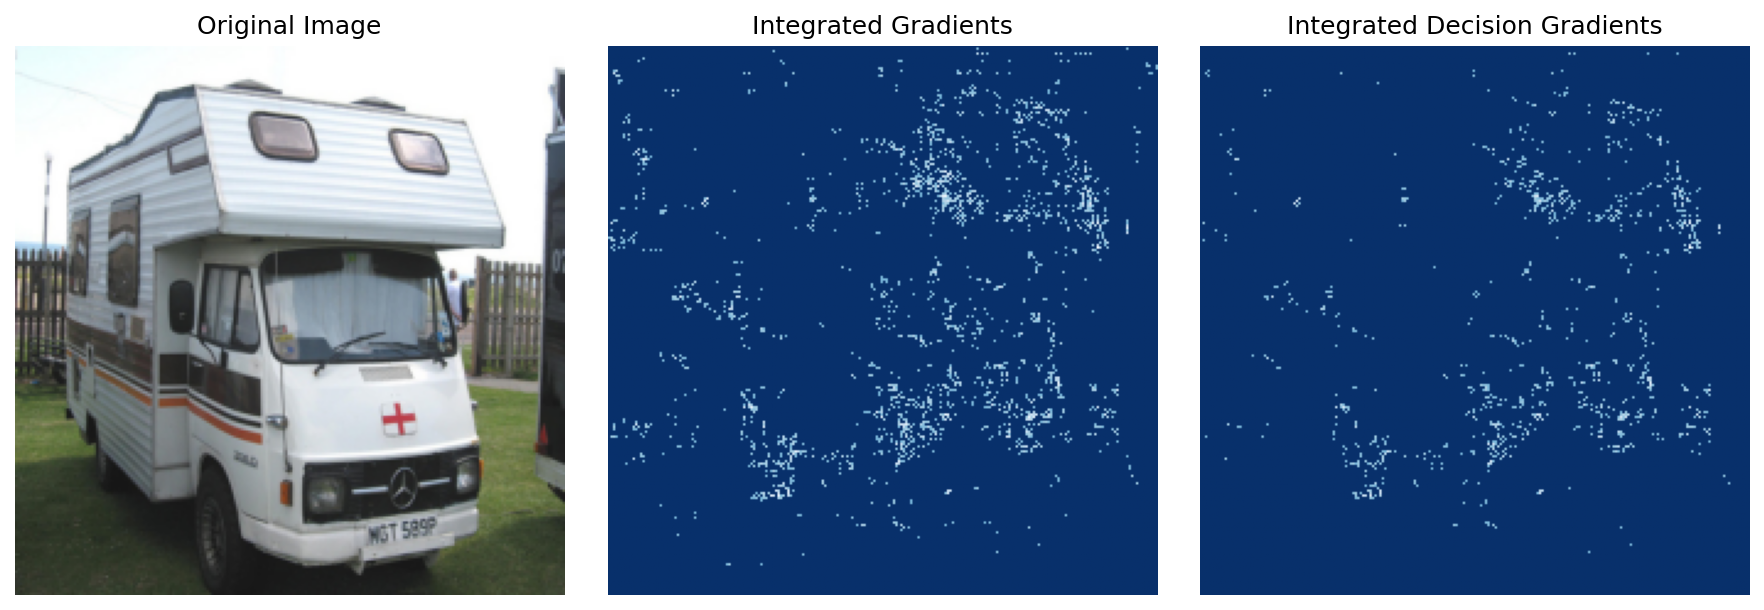

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import requests
from io import BytesIO
import gc

# -------- Attribution Core Methods --------
def compute_gradients(inputs, model, target_class):
    inputs.requires_grad = True
    outputs = model(inputs)
    scores = outputs[:, target_class]
    gradients = torch.autograd.grad(outputs=scores, inputs=inputs, grad_outputs=torch.ones_like(scores))[0]
    return gradients, scores

def integrated_gradients(input_tensor, model, steps, baseline, target_class, device):
    input_tensor = input_tensor.to(device)
    baseline = baseline.to(device)
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs)
    gradients, _ = compute_gradients(scaled_inputs, model, target_class)
    avg_gradients = gradients.view(steps + 1, *input_tensor.shape[1:]).mean(dim=0)
    integrated_grad = (input_tensor - baseline) * avg_gradients
    return integrated_grad.squeeze()

def integrated_decision_gradients(input_tensor, model, steps, baseline, target_class, device):
    input_tensor = input_tensor.to(device)
    baseline = baseline.to(device)
    scaled_inputs = [baseline + (float(i) / steps) * (input_tensor - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs)
    gradients, scores = compute_gradients(scaled_inputs, model, target_class)
    score_diffs = scores[1:] - scores[:-1]
    importance_factors = torch.cat([torch.tensor([0.0], device=device), score_diffs])
    weighted_gradients = gradients * importance_factors.view(-1, 1, 1, 1)
    avg_gradients = weighted_gradients.view(steps + 1, *input_tensor.shape[1:]).mean(dim=0)
    integrated_grad = (input_tensor - baseline) * avg_gradients
    return integrated_grad.squeeze()

# -------- Image Preprocessing --------
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    if image_path.startswith(('http://', 'https://')):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    return input_tensor

def enhance_map(attr, threshold=0.2, gamma=0.4):
    attr = attr.detach().cpu().numpy()
    attr = np.abs(attr)
    attr = np.mean(attr, axis=0) if attr.ndim == 3 else attr
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    attr = np.where(attr > threshold, attr, 0)
    attr = np.power(attr, gamma)
    return attr

def visualize_attributions(input_image, ig_attr, idg_attr):
    ig_attr = enhance_map(ig_attr)
    idg_attr = enhance_map(idg_attr)
    input_image = input_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

    axs[0].imshow(input_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    axs[1].imshow(ig_attr, cmap='Blues_r')
    axs[1].axis('off')
    axs[1].set_title('Integrated Gradients')

    axs[2].imshow(idg_attr, cmap='Blues_r')
    axs[2].axis('off')
    axs[2].set_title('Integrated Decision Gradients')

    plt.tight_layout()
    plt.show()

def main():
    torch.cuda.empty_cache()
    gc.collect()

    device = torch.device('cpu')  # FOR STABILITY, USE CPU TO AVOID OOM
    model = models.resnet50(pretrained=True)
    model.eval()

    image_path = r"C:\Users\VISHNU\recreational_vehicle.JPEG"
    target_class = 757  # Example: recreational vehicle

    input_tensor = preprocess_image(image_path, device)
    baseline = torch.zeros_like(input_tensor)

    ig_attr = integrated_gradients(input_tensor, model, steps=100, baseline=baseline, target_class=target_class, device=device)
    idg_attr = integrated_decision_gradients(input_tensor, model, steps=100, baseline=baseline, target_class=target_class, device=device)

    visualize_attributions(input_tensor, ig_attr, idg_attr)

if __name__ == "__main__":
    main()